# Project: Analyzing Global Trends in Renewable Energy Adoption

**Author:** Wil Watkins
**Date:** June 7, 2025

### 1. Project Objective
The goal of this project is to analyze global, regional, and national trends in renewable energy adoption between 2000 and 2020. By cleaning, processing, and visualizing data from the World Bank, we aim to answer key questions about which regions and countries are leading the energy transition, what sources are driving growth, and what the overall global progress looks like.

### 2. Data Source
The data for this project was sourced from the World Bank's World Development Indicators dataset, accessed on [Date of your download]. The four key indicators used are:
* Renewable energy consumption (% of total final energy consumption)
* Renewable electricity output (% of total electricity output)
* Electricity production from renewable sources, excluding hydroelectric (kWh)
* Electricity production from hydroelectric sources (kWh)

### 3. Tools Used
* Python
* Pandas (for data manipulation and analysis)
* Matplotlib & Seaborn (for data visualization)
* Google Colab (as the development environment)

### 4. Data Loading and Initial Inspection
The first step was to load our datasets. When first attempting to load the CSV files from the World Bank, a `ParserError` was encountered. This is because the raw files contained several lines of metadata at the top before the actual data table begins.

**Rationale for the cleaning step:** To resolve this, we used the `skiprows` parameter in `pd.read_csv()`. By inspecting each file, we determined the correct number of initial rows to skip, allowing pandas to correctly parse the structured data table. We then started by loading and inspecting the first indicator: Renewable Energy Consumption.

In [9]:
import pandas as pd

file_name = 'Renewable Energy Consumption.csv' # Or your exact file name

# Replace N with the actual number of lines you need to skip
# For example, if you need to skip 4 lines, it would be skiprows=4
try:
    df = pd.read_csv(file_name, skiprows=3) # <--- ADD skiprows=3 HERE
    print(f"Successfully loaded {file_name} after skipping {3} rows.")

    # Now let's do the initial inspection
    print("\nFirst 5 rows of the DataFrame (df.head()):")
    print(df.head())

    print("\nDataFrame Info (df.info()):")
    df.info()

    print("\nDataFrame Shape (df.shape):")
    print(df.shape)

except Exception as e:
    print(f"An error occurred: {e}")

# Make a copy to preserve the original df if you want to experiment
df_cleaned = df.copy()

# 1. Drop the 'Unnamed: 69' column
if 'Unnamed: 69' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['Unnamed: 69'])
    print("Dropped 'Unnamed: 69' column.")

# 2. Define the columns to keep: Identifiers + years 2000-2022
# First, get the list of columns that represent years we want to keep.
# The year columns are strings, e.g., '2000', '2001', ... , '2022'.
years_to_keep = [str(year) for year in range(2000, 2023)] # range(2000, 2023) goes up to 2022

# Ensure only existing year columns are selected (in case some years in the range are missing)
actual_years_to_keep = [year for year in years_to_keep if year in df_cleaned.columns]

# Define the identifier columns you definitely want to keep
identifier_columns = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']

# Combine identifier columns and the actual year columns to keep
columns_to_keep = identifier_columns + actual_years_to_keep

# Select only these columns
df_cleaned = df_cleaned[columns_to_keep]

print(f"\nSelected columns: {df_cleaned.columns.tolist()}")
print("\nFirst 5 rows of df_cleaned (df_cleaned.head()):")
print(df_cleaned.head())
print("\nShape of df_cleaned (df_cleaned.shape):")
print(df_cleaned.shape)

# df_cleaned should be the output from the previous step

# Melt the DataFrame
df_long = pd.melt(df_cleaned,
                  id_vars=identifier_columns,  # Columns to keep as identifiers
                  value_vars=actual_years_to_keep,  # Columns to unpivot (the year columns)
                  var_name='Year',          # Name for the new column holding year values
                  value_name='Consumption_Percent') # Name for the new column holding data values

print("\nFirst 5 rows of the long format DataFrame (df_long.head()):")
print(df_long.head())
print("\nLast 5 rows of the long format DataFrame (df_long.tail()):")
print(df_long.tail())
print("\nShape of df_long (df_long.shape):")
print(df_long.shape)
print("\nInfo of df_long (df_long.info()):")
df_long.info()

# df_long should be the output from the previous step

# Convert 'Year' column to integer
df_long['Year'] = pd.to_numeric(df_long['Year'])

# Convert 'Consumption_Percent' to numeric as well (it should be already, but good practice)
df_long['Consumption_Percent'] = pd.to_numeric(df_long['Consumption_Percent'], errors='coerce')


print("\nInfo of df_long after converting 'Year' to numeric (df_long.info()):")
df_long.info()
print("\nFirst 5 rows of df_long after data type conversion:")
print(df_long.head())

Successfully loaded Renewable Energy Consumption.csv after skipping 3 rows.

First 5 rows of the DataFrame (df.head()):
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name  Indicator Code  1960  \
0  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS   NaN   
1  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS   NaN   
2  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS   NaN   
3  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS   NaN   
4  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS   NaN   

   1961  1962  1963  1964  1965  ...       2016       2017       2018  \
0   NaN   NaN   NaN   NaN   NaN  ...   7.000000   6.800

### 5. Data Cleaning and Reshaping
The raw data was in a "wide" format, with each year as a separate column. This format was not ideal for time-series analysis. Our goal was to transform this into a "long" format, where we have one column for 'Year' and one for the data value.

**Rationale for the cleaning steps:**
1.  **Drop Unnecessary Columns:** We dropped any empty columns (e.g., 'Unnamed: 69') and year columns outside our primary scope of interest (2000-2020) to create a focused and tidy dataset.
2.  **Melt the DataFrame:** We used the `pd.melt()` function to reshape the data. This "unpivots" the year columns into a single 'Year' column, making it much easier to plot trends and group data by country or year.
3.  **Convert Data Types:** We ensured the 'Year' column is a numeric type (integer) for proper sorting and plotting.

### 6. Creating a Reusable Processing Function
Since we had four datasets that all share the same structure, repeating the cleaning and reshaping steps manually would be inefficient and prone to error.

**Rationale:** To streamline the process, we created a single Python function called `process_world_bank_data`. This function encapsulated all of our cleaning and reshaping logic. We can then called this function for each of the remaining raw data files, ensuring consistency and making our code much cleaner and more efficient.

In [10]:
def process_world_bank_data(raw_df, value_column_name, start_year=2000, end_year=2022):
    """
    Cleans and reshapes a raw World Bank data DataFrame.

    Args:
        raw_df (pd.DataFrame): The raw DataFrame loaded from CSV (after skipping initial rows).
        value_column_name (str): The desired name for the data column after melting (e.g., 'Consumption_Percent').
        start_year (int): The first year to include in the cleaned data.
        end_year (int): The last year to include in the cleaned data.

    Returns:
        pd.DataFrame: A cleaned and reshaped DataFrame in long format, or None if an error occurs.
    """
    try:
        print(f"Starting processing for indicator: {raw_df['Indicator Name'].iloc[0] if 'Indicator Name' in raw_df.columns else 'Unknown'}")
        df_processed = raw_df.copy()

        # 1. Drop potential 'Unnamed' columns (generalizing for any trailing unnamed column)
        unnamed_cols = [col for col in df_processed.columns if 'Unnamed:' in col]
        if unnamed_cols:
            df_processed = df_processed.drop(columns=unnamed_cols)
            print(f"Dropped unnamed columns: {unnamed_cols}")

        # 2. Define columns to keep
        years_to_keep_str = [str(year) for year in range(start_year, end_year + 1)]

        # Filter out year columns that might not exist in the dataframe
        actual_years_to_keep = [year for year in years_to_keep_str if year in df_processed.columns]
        if not actual_years_to_keep:
            print(f"Error: No year columns found in the range {start_year}-{end_year} in the provided DataFrame.")
            return None

        identifier_columns = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']

        # Ensure identifier columns exist
        missing_identifiers = [col for col in identifier_columns if col not in df_processed.columns]
        if missing_identifiers:
            print(f"Error: Missing expected identifier columns: {missing_identifiers}")
            return None

        columns_to_keep = identifier_columns + actual_years_to_keep
        df_processed = df_processed[columns_to_keep]
        print(f"Selected columns. Shape: {df_processed.shape}")

        # 3. Melt the DataFrame
        df_long_processed = pd.melt(df_processed,
                                    id_vars=identifier_columns,
                                    value_vars=actual_years_to_keep,
                                    var_name='Year',
                                    value_name=value_column_name)
        print(f"Melted data. Shape: {df_long_processed.shape}")

        # 4. Convert 'Year' and value column to numeric
        df_long_processed['Year'] = pd.to_numeric(df_long_processed['Year'])
        df_long_processed[value_column_name] = pd.to_numeric(df_long_processed[value_column_name], errors='coerce')
        print(f"Converted 'Year' to int and '{value_column_name}' to float.")

        print("Processing complete.\n")
        return df_long_processed

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        return None

In [11]:
 import pandas as pd # Ensure pandas is imported

# --- Part 1: Load the NEW raw CSV file ---
# Replace 'YOUR_NEW_FILE_NAME.csv' with the actual name of your uploaded file for this indicator
# Replace N with the correct number of rows to skip for THIS FILE
new_file_name = 'Renewable Electricity Output.csv'
rows_to_skip_for_new_file = 3 # Determine this by inspecting the new file

try:
    df_raw_elec_output_pct = pd.read_csv("Renewable Electricity Output.csv", skiprows=rows_to_skip_for_new_file)
    print(f"Successfully loaded raw data from: {new_file_name}")

    # --- Part 2: Process the loaded data using our function ---
    # Give a descriptive name for the value column for this indicator
    value_col_name = 'ElecOutputRenewable_Percent'

    # Call the processing function
    df_elec_output_pct_long = process_world_bank_data(df_raw_elec_output_pct, value_col_name)

    # --- Part 3: Display results if processing was successful ---
    if df_elec_output_pct_long is not None:
        print("\n--- Processed DataFrame (df_elec_output_pct_long) ---")
        print("\nHead of the processed DataFrame:")
        print(df_elec_output_pct_long.head())

        print("\nInfo of the processed DataFrame:")
        df_elec_output_pct_long.info()

        # You can also check the shape
        print("\nShape of the processed DataFrame:")
        print(df_elec_output_pct_long.shape)

except FileNotFoundError:
    print(f"Error: The file '{new_file_name}' was not found. Please check the name and ensure it's uploaded.")
except Exception as e:
    print(f"An error occurred loading or processing the new file: {e}")

Successfully loaded raw data from: Renewable Electricity Output.csv
Starting processing for indicator: Renewable electricity output (% of total electricity output)
Dropped unnamed columns: ['Unnamed: 69']
Selected columns. Shape: (266, 27)
Melted data. Shape: (6118, 6)
Converted 'Year' to int and 'ElecOutputRenewable_Percent' to float.
Processing complete.


--- Processed DataFrame (df_elec_output_pct_long) ---

Head of the processed DataFrame:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name  Indicator Code  Year  \
0  Renewable electricity output (% of total elect...  EG.ELC.RNEW.ZS  2000   
1  Renewable electricity output (% of total elect...  EG.ELC.RNEW.ZS  2000   
2  Renewable electricity output (%

In [12]:
# --- Processing File 3: Non-Hydroelectric Renewable Production ---

print("--- Starting File 3: Non-Hydro Renewable Production (kWh) ---")

# 1. DEFINE YOUR FILENAME AND SKIP ROWS VALUE
# !!! IMPORTANT: Replace with your actual file name and the number of rows to skip for THIS file !!!
file_to_process = 'Renew Electric WO Hydro.csv'
rows_to_skip = 3

# 2. LOAD AND PROCESS THE FILE USING THE FUNCTION
try:
    # Load the raw data from the CSV
    df_raw_prod_nonhydro = pd.read_csv("Renew Electric WO Hydro.csv", skiprows=rows_to_skip)
    print(f"\nSuccessfully loaded raw data from: {file_to_process}")

    # Call our function to clean and reshape the data
    df_prod_nonhydro_long = process_world_bank_data(
        raw_df=df_raw_prod_nonhydro,
        value_column_name='Prod_NonHydro_kWh'  # Descriptive name for the data column
    )

    # 3. DISPLAY RESULTS
    if df_prod_nonhydro_long is not None:
        print("\n--- Results for Non-Hydro Production DataFrame ---")
        print("\nHead of the processed DataFrame:")
        print(df_prod_nonhydro_long.head())

        print("\nInfo of the processed DataFrame:")
        df_prod_nonhydro_long.info()

except Exception as e:
    print(f"\nAn error occurred: {e}")

print("\n--- Finished processing File 3 ---")

--- Starting File 3: Non-Hydro Renewable Production (kWh) ---

Successfully loaded raw data from: Renew Electric WO Hydro.csv
Starting processing for indicator: Electricity production from renewable sources, excluding hydroelectric (kWh)
Dropped unnamed columns: ['Unnamed: 69']
Selected columns. Shape: (266, 27)
Melted data. Shape: (6118, 6)
Converted 'Year' to int and 'Prod_NonHydro_kWh' to float.
Processing complete.


--- Results for Non-Hydro Production DataFrame ---

Head of the processed DataFrame:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name  Indicator Code  Year  \
0  Electricity production from renewable sources,...  EG.ELC.RNWX.KH  2000   
1  Electricity production from renewable sources,..

In [13]:
# --- Processing File 4: Hydroelectric Renewable Production ---

print("--- Starting File 4: Hydroelectric Production (kWh) ---")

# 1. DEFINE YOUR FILENAME AND SKIP ROWS VALUE
# !!! IMPORTANT: Replace with your actual file name and the number of rows to skip for THIS file !!!
file_to_process = 'Electric Pro from Hydro.csv'
rows_to_skip = 3

# 2. LOAD AND PROCESS THE FILE USING THE FUNCTION
try:
    # Load the raw data from the CSV
    df_raw_prod_hydro = pd.read_csv("Electric Pro from Hydro.csv", skiprows=rows_to_skip)
    print(f"\nSuccessfully loaded raw data from: {file_to_process}")

    # Call our function to clean and reshape the data
    df_prod_hydro_long = process_world_bank_data(
        raw_df=df_raw_prod_hydro,
        value_column_name='Prod_Hydro_kWh'  # Descriptive name for the data column
    )

    # 3. DISPLAY RESULTS
    if df_prod_hydro_long is not None:
        print("\n--- Results for Hydro Production DataFrame ---")
        print("\nHead of the processed DataFrame:")
        print(df_prod_hydro_long.head())

        print("\nInfo of the processed DataFrame:")
        df_prod_hydro_long.info()

except Exception as e:
    print(f"\nAn error occurred: {e}")

print("\n--- Finished processing File 4 ---")

--- Starting File 4: Hydroelectric Production (kWh) ---

Successfully loaded raw data from: Electric Pro from Hydro.csv
Starting processing for indicator: Electricity production from hydroelectric sources (% of total)
Dropped unnamed columns: ['Unnamed: 69']
Selected columns. Shape: (266, 27)
Melted data. Shape: (6118, 6)
Converted 'Year' to int and 'Prod_Hydro_kWh' to float.
Processing complete.


--- Results for Hydro Production DataFrame ---

Head of the processed DataFrame:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name  Indicator Code  Year  \
0  Electricity production from hydroelectric sour...  EG.ELC.HYRO.ZS  2000   
1  Electricity production from hydroelectric sour...  EG.ELC.HYRO.ZS  2000   


### 7. Merging the Datasets
With all four indicators cleaned and processed into a consistent long format, the next step was to merge them into a single, master DataFrame.

**Rationale:** A consolidated DataFrame allowed us to easily compare different metrics for the same country and year. We used an `outer` merge to ensure no data wass lost during the process. To avoid errors with conflicting column names, we first selected only the necessary columns (identifiers, year, and the unique value column) from each DataFrame before merging. Finally, we created a new feature, `Total_Prod_kWh`, by summing the hydro and non-hydro production values.

In [15]:
# --- New & Improved Merge and Cleanup Step ---

print("Starting the merge with a cleaner strategy...")

try:
    # 1. Select ONLY the columns we need from each DataFrame
    # This prevents the 'Indicator Name/Code' columns from causing suffix issues.
    df1 = df_long[['Country Name', 'Country Code', 'Year', 'Consumption_Percent']]
    df2 = df_elec_output_pct_long[['Country Name', 'Country Code', 'Year', 'ElecOutputRenewable_Percent']]
    df3 = df_prod_nonhydro_long[['Country Name', 'Country Code', 'Year', 'Prod_NonHydro_kWh']]
    df4 = df_prod_hydro_long[['Country Name', 'Country Code', 'Year', 'Prod_Hydro_kWh']]
    print("Selected necessary columns from each DataFrame.")

    # 2. Put the selected DataFrames into a list and merge them sequentially
    dfs_to_merge = [df1, df2, df3, df4]

    # Initialize our final DataFrame with the first one in the list
    final_df = dfs_to_merge[0]

    # Loop through the rest of the DataFrames and merge them
    for df_to_merge in dfs_to_merge[1:]:
        final_df = pd.merge(final_df, df_to_merge, on=['Country Name', 'Country Code', 'Year'], how='outer')

    print("Merge complete.")

    # 3. Create a 'Total Production' column (this step is still needed)
    # The .sum(axis=1) method across columns handles NaNs gracefully.
    final_df['Total_Prod_kWh'] = final_df[['Prod_NonHydro_kWh', 'Prod_Hydro_kWh']].sum(axis=1, min_count=1)
    print("Created 'Total_Prod_kWh' column.")


    # 4. Final Inspection
    print("\n--- Final, Cleaned DataFrame ---")
    print("\nHead of the final DataFrame:")
    print(final_df.head())

    print("\nInfo of the final DataFrame:")
    final_df.info()

    print("\nShape of the final DataFrame:")
    print(final_df.shape)

except NameError as e:
    print(f"\nA NameError occurred: {e}")
    print("This likely means one of the initial DataFrames (e.g., df_long) wasn't created.")
    print("Please try 'Runtime -> Run all' again to ensure all cells execute in order.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Starting the merge with a cleaner strategy...
Selected necessary columns from each DataFrame.
Merge complete.
Created 'Total_Prod_kWh' column.

--- Final, Cleaned DataFrame ---

Head of the final DataFrame:
  Country Name Country Code  Year  Consumption_Percent  \
0  Afghanistan          AFG  2000                 45.0   
1  Afghanistan          AFG  2001                 45.6   
2  Afghanistan          AFG  2002                 37.8   
3  Afghanistan          AFG  2003                 36.7   
4  Afghanistan          AFG  2004                 44.2   

   ElecOutputRenewable_Percent  Prod_NonHydro_kWh  Prod_Hydro_kWh  \
0                    93.537318                0.0       93.537318   
1                    93.537318                0.0       93.537318   
2                    93.537450                0.0       93.537450   
3                    80.630860                0.0       80.630860   
4                    62.864936                0.0       62.864936   

   Total_Prod_kWh  
0       9

### 8. Exploratory Data Analysis (EDA) & Visualization
Now that we had a clean, consolidated dataset, we began our analysis. We moved from a high-level global view down to specific country and regional comparisons.

#### **Analysis 1: What is the Overall Global Trend?**
**Goal:** To understand the big-picture trend of renewable energy adoption on a global scale.
**Methodology:** We filtered our dataset for the 'World' aggregate data provided by the World Bank and plot key metrics over time.

##### **Chart Analysis: Global Trends**
The initial plots revealed a significant, misleading drop-off in the data after 2020. This is a classic data quality issue caused by reporting lags; the data for 2021 and 2022 is incomplete. After filtering the data to the last complete year (2020), the corrected charts show a clear and consistent story:
* The share of renewables in *total energy consumption* (which includes heating and transport) is growing very slowly.
* The share of renewables in *electricity output*, however, shows a much more promising and accelerating upward trend, growing from about 19% in 2000 to over 28% in 2020.
* The absolute production of renewable electricity (in kWh) has grown exponentially, especially after 2010.

In [16]:
# --- Analysis 1: Global Trends ---

# Filter the final_df to get only the rows for 'World'
df_world = final_df[final_df['Country Name'] == 'World'].copy()

# Sort by year to ensure our line plots are correct
df_world = df_world.sort_values(by='Year')

print("Created a new DataFrame 'df_world' containing only global data.")
print(df_world.head())

Created a new DataFrame 'df_world' containing only global data.
     Country Name Country Code  Year  Consumption_Percent  \
6026        World          WLD  2000            17.590003   
6027        World          WLD  2001            17.263026   
6028        World          WLD  2002            17.274473   
6029        World          WLD  2003            17.120187   
6030        World          WLD  2004            16.818463   

      ElecOutputRenewable_Percent  Prod_NonHydro_kWh  Prod_Hydro_kWh  \
6026                    18.886342       2.260672e+11       17.428489   
6027                    18.393846       2.274545e+11       16.938059   
6028                    18.317180       2.542467e+11       16.750949   
6029                    17.812535       2.647814e+11       16.239231   
6030                    18.260850       3.130979e+11       16.482205   

      Total_Prod_kWh  
6026    2.260672e+11  
6027    2.274545e+11  
6028    2.542467e+11  
6029    2.647814e+11  
6030    3.130979e+11 

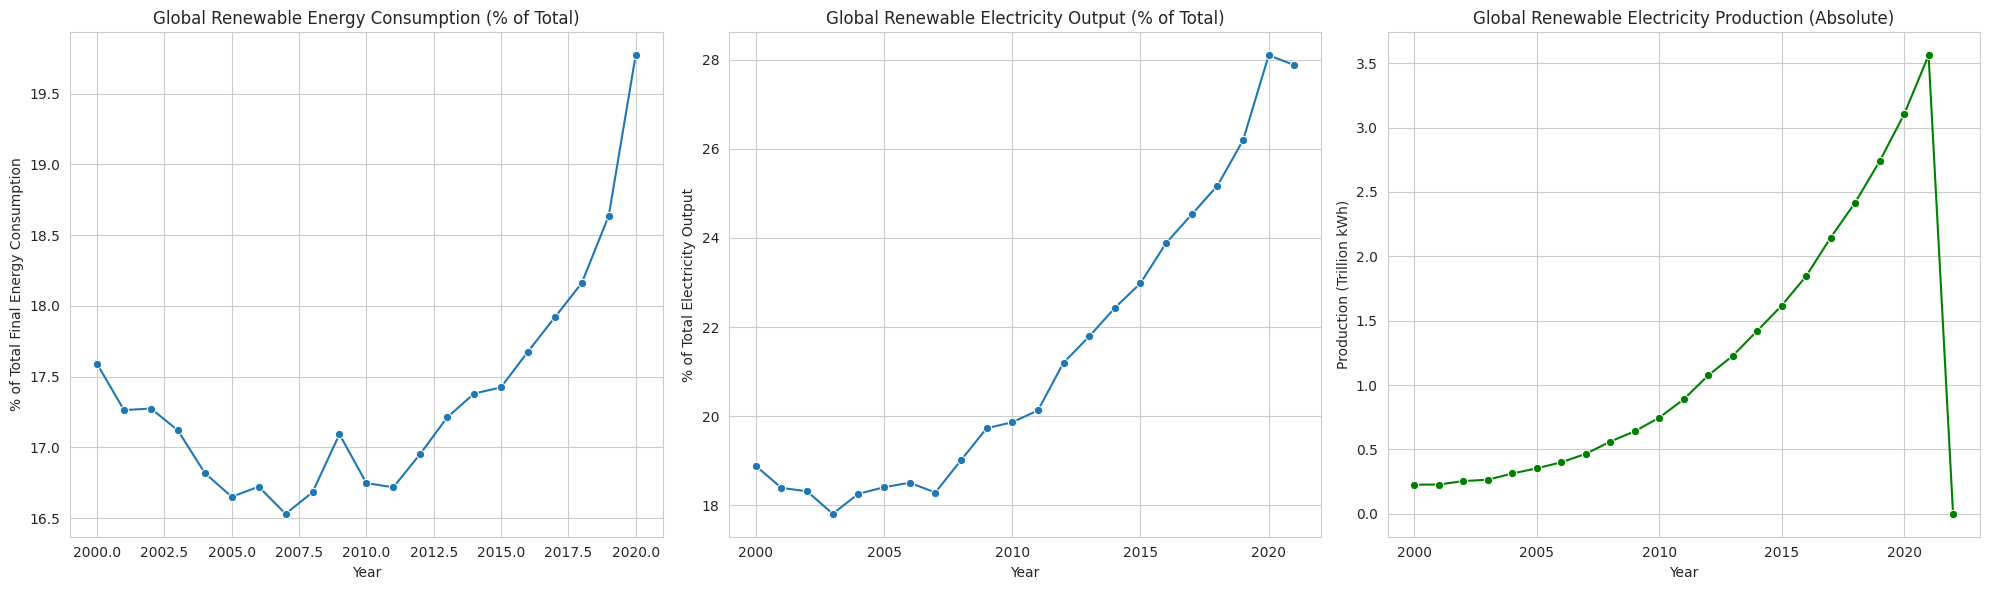

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for our plots
sns.set_style("whitegrid")

# Create a figure and a set of subplots
# 1 row, 3 columns of plots. figsize controls the overall size.
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot 1: Consumption Percentage ---
sns.lineplot(ax=axes[0], x='Year', y='Consumption_Percent', data=df_world, marker='o')
axes[0].set_title('Global Renewable Energy Consumption (% of Total)')
axes[0].set_ylabel('% of Total Final Energy Consumption')
axes[0].set_xlabel('Year')

# --- Plot 2: Electricity Output Percentage ---
sns.lineplot(ax=axes[1], x='Year', y='ElecOutputRenewable_Percent', data=df_world, marker='o')
axes[1].set_title('Global Renewable Electricity Output (% of Total)')
axes[1].set_ylabel('% of Total Electricity Output')
axes[1].set_xlabel('Year')

# --- Plot 3: Absolute Production (in Trillion kWh) ---
# We convert kWh to Trillion kWh for easier reading on the y-axis
df_world['Total_Prod_Trillion_kWh'] = df_world['Total_Prod_kWh'] / 1e12
sns.lineplot(ax=axes[2], x='Year', y='Total_Prod_Trillion_kWh', data=df_world, marker='o', color='green')
axes[2].set_title('Global Renewable Electricity Production (Absolute)')
axes[2].set_ylabel('Production (Trillion kWh)')
axes[2].set_xlabel('Year')

# Adjust layout to prevent titles from overlapping
plt.tight_layout()

# Display the plots
plt.show()

In [18]:
# Inspect the last few rows of the df_world DataFrame
print(df_world.tail(5))

     Country Name Country Code  Year  Consumption_Percent  \
6044        World          WLD  2018            18.162225   
6045        World          WLD  2019            18.636542   
6046        World          WLD  2020            19.771344   
6047        World          WLD  2021                  NaN   
6048        World          WLD  2022                  NaN   

      ElecOutputRenewable_Percent  Prod_NonHydro_kWh  Prod_Hydro_kWh  \
6044                    25.173390       2.418009e+12       16.146126   
6045                    26.192965       2.738354e+12       16.100143   
6046                    28.099222       3.103193e+12       16.586788   
6047                    27.878485       3.562021e+12       15.435773   
6048                          NaN                NaN       15.243454   

      Total_Prod_kWh  Total_Prod_Trillion_kWh  
6044    2.418009e+12             2.418009e+00  
6045    2.738354e+12             2.738354e+00  
6046    3.103193e+12             3.103193e+00  
6047    

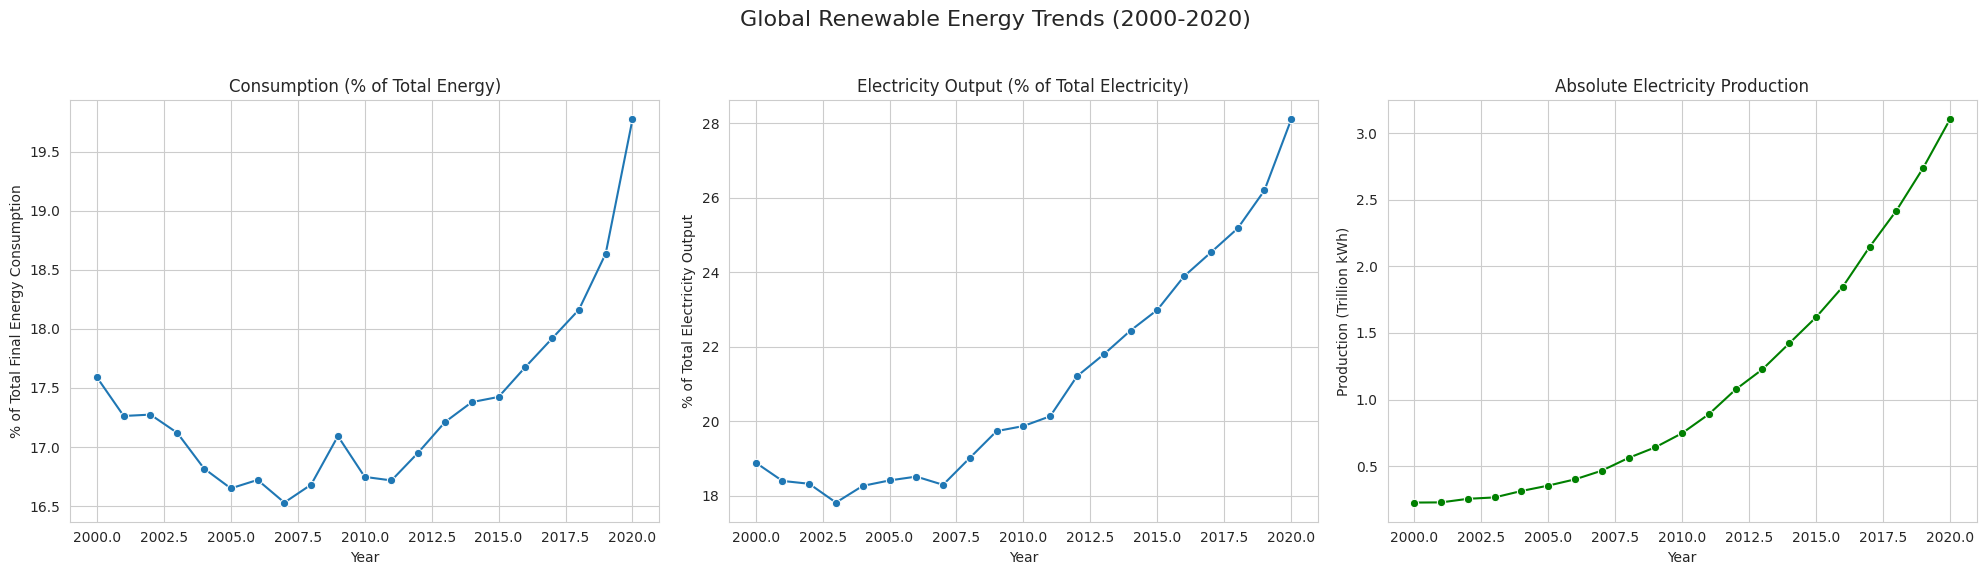

In [19]:
# --- Corrected Global Trends Visualization (up to 2020) ---

# Filter the data to include years up to 2020 for a more reliable trend
df_world_filtered = df_world[df_world['Year'] <= 2020]

# Set the style for our plots
sns.set_style("whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Global Renewable Energy Trends (2000-2020)', fontsize=16) # Add a main title

# --- Plot 1: Consumption Percentage ---
sns.lineplot(ax=axes[0], x='Year', y='Consumption_Percent', data=df_world_filtered, marker='o')
axes[0].set_title('Consumption (% of Total Energy)')
axes[0].set_ylabel('% of Total Final Energy Consumption')
axes[0].set_xlabel('Year')

# --- Plot 2: Electricity Output Percentage ---
sns.lineplot(ax=axes[1], x='Year', y='ElecOutputRenewable_Percent', data=df_world_filtered, marker='o')
axes[1].set_title('Electricity Output (% of Total Electricity)')
axes[1].set_ylabel('% of Total Electricity Output')
axes[1].set_xlabel('Year')

# --- Plot 3: Absolute Production (in Trillion kWh) ---
sns.lineplot(ax=axes[2], x='Year', y='Total_Prod_Trillion_kWh', data=df_world_filtered, marker='o', color='green')
axes[2].set_title('Absolute Electricity Production')
axes[2].set_ylabel('Production (Trillion kWh)')
axes[2].set_xlabel('Year')

# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle

# Display the plots
plt.show()

#### **Analysis 2: What is the Source of Growth?**
**Goal:** To understand the composition of the electricity sector and see how the share of renewables has grown relative to non-renewables.
**Methodology:** After discovering data quality issues with the absolute production data for the 'World' aggregate, we pivoted our analysis. We used the reliable `ElecOutputRenewable_Percent` metric to create a stacked area chart showing the share of renewable vs. non-renewable sources in the global electricity mix over time.

##### **Chart Analysis: Share of Global Electricity Production**
The chart clearly visualizes the "squeezing" of non-renewable sources. From 2000 to 2020, renewable energy sources have expanded to cover about 10 additional percentage points of the global electricity supply. The growth is slow but steady, and the chart shows a clear acceleration in the trend after 2010, indicating a growing momentum in the energy transition.

In [26]:
# --- Analysis 2: Source-Specific Growth ---

# Prepare the data from our filtered world dataframe
years = df_world_filtered['Year']
# Convert kWh to Trillion kWh
hydro_prod = df_world_filtered['Prod_Hydro_kWh'] / 1e12
non_hydro_prod = df_world_filtered['Prod_NonHydro_kWh'] / 1e12

# Define labels for our plot
plot_labels = ['Hydroelectric Production', 'Non-Hydro Production (Solar, Wind, etc.)']

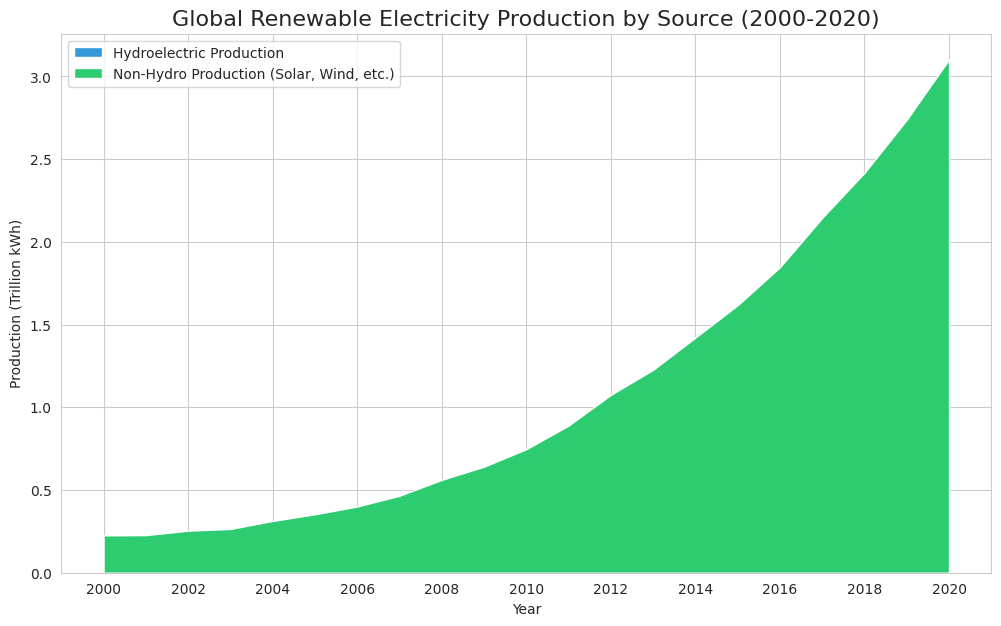

In [23]:
# Set the style for the plot
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 7))

# Create the stacked area plot
plt.stackplot(years, hydro_prod, non_hydro_prod, labels=plot_labels, colors=['#3498db', '#2ecc71'])

# Add title and labels
plt.title('Global Renewable Electricity Production by Source (2000-2020)', fontsize=16)
plt.ylabel('Production (Trillion kWh)')
plt.xlabel('Year')

# Add a legend to identify the sources
plt.legend(loc='upper left')

# Ensure the x-axis ticks are integers for years
plt.xticks(years[::2]) # Show every second year to avoid clutter

# Display the plot
plt.show()

In [27]:
# --- Diagnostic Code ---
# Let's inspect the data we are trying to plot

print("--- Inspecting the data for the stacked area chart ---")

# Create a DataFrame to easily view the variables side-by-side
diagnostic_df = pd.DataFrame({
    'Year': years,
    'Hydro_Production_Trillion_kWh': hydro_prod,
    'NonHydro_Production_Trillion_kWh': non_hydro_prod
})

# Display the entire diagnostic DataFrame
# We use pd.set_option to make sure we see all the rows.
pd.set_option('display.max_rows', None)
print(diagnostic_df)
pd.reset_option('display.max_rows') # Reset the option

--- Inspecting the data for the stacked area chart ---
      Year  Hydro_Production_Trillion_kWh  NonHydro_Production_Trillion_kWh
6026  2000                   1.742849e-11                          0.226067
6027  2001                   1.693806e-11                          0.227455
6028  2002                   1.675095e-11                          0.254247
6029  2003                   1.623923e-11                          0.264781
6030  2004                   1.648220e-11                          0.313098
6031  2005                   1.648209e-11                          0.353450
6032  2006                   1.641192e-11                          0.400384
6033  2007                   1.594886e-11                          0.465665
6034  2008                   1.624454e-11                          0.561419
6035  2009                   1.655912e-11                          0.641258
6036  2010                   1.640840e-11                          0.747050
6037  2011                   1.61

In [28]:
# --- Analysis 2 (Revised): Share of Electricity Production ---

# We use our reliable filtered world data (up to 2020)
years = df_world_filtered['Year']
renewable_share = df_world_filtered['ElecOutputRenewable_Percent']

# Calculate the non-renewable share
non_renewable_share = 100 - renewable_share

# Define labels for our plot
plot_labels = ['Non-Renewable', 'Renewable']
plot_colors = ['#808080', '#2ecc71'] # Gray for non-renewable, green for renewable

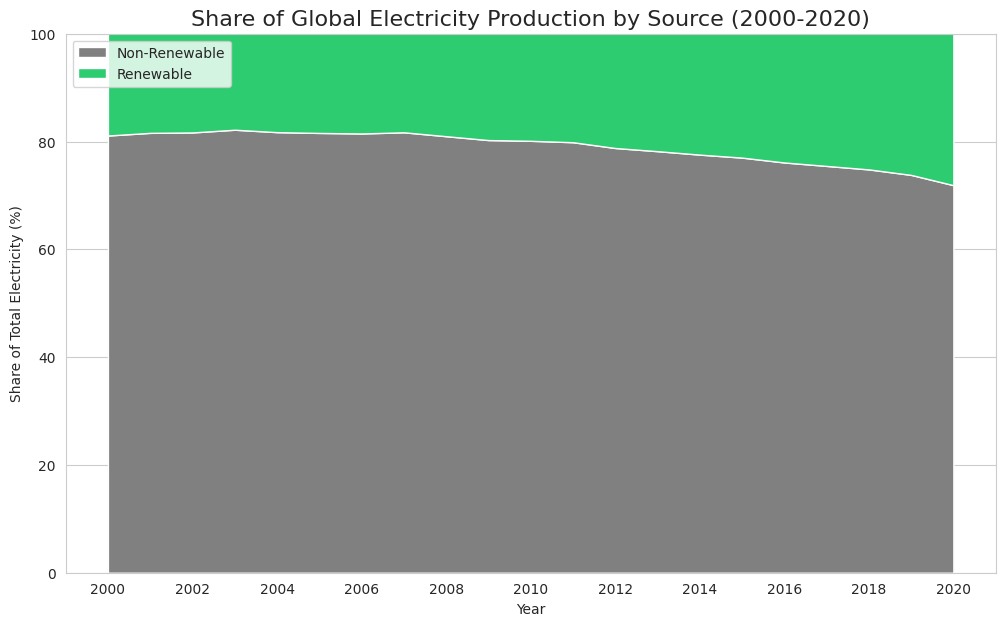

In [29]:
# Set the style for the plot
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 7))

# Create the stacked area plot
plt.stackplot(years, non_renewable_share, renewable_share, labels=plot_labels, colors=plot_colors)

# Add title and labels
plt.title('Share of Global Electricity Production by Source (2000-2020)', fontsize=16)
plt.ylabel('Share of Total Electricity (%)')
plt.xlabel('Year')

# Set the y-axis to go from 0 to 100
plt.ylim(0, 100)

# Add a legend to identify the sources
plt.legend(loc='upper left')

# Ensure the x-axis ticks are integers for years
plt.xticks(years[::2]) # Show every second year

# Display the plot
plt.show()

#### **Analysis 3: Which Countries are the Leaders?**
**Goal:** To move beyond the global average and identify which individual countries are leading in renewable energy adoption.
**Methodology:** We filtered the data for a single snapshot year (2020) and created two "Top 10" leaderboards. A crucial step was to first remove all aggregate regions (e.g., 'World', 'European Union') to ensure a fair comparison of individual countries.

##### **Chart Analysis: Country Leaderboards**
The two leaderboards reveal a critical insight: leadership depends entirely on the metric used.
* **Leaders in Total Consumption:** This list is dominated by African nations. This high share is primarily due to a reliance on traditional biomass (wood, charcoal) for basic needs like cooking, not a modern, green electricity grid.
* **Leaders in Electricity Output:** This list features countries like Norway, Iceland, and Costa Rica. Their leadership is a result of geography (massive hydropower or geothermal resources) and decades of investment in modern renewable technology. This highlights that "renewable electricity share" is a better metric for tracking progress in the modern energy transition.

In [30]:
# --- Analysis 3: Country Leaderboards ---

# List of aggregate regions to exclude from our country ranking
# This list is based on common World Bank aggregates.
aggregates_to_exclude = [
    'Africa Eastern and Southern', 'Africa Western and Central', 'Arab World',
    'Caribbean small states', 'Central Europe and the Baltics', 'Early-demographic dividend',
    'East Asia & Pacific', 'Euro area', 'Europe & Central Asia', 'European Union',
    'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)',
    'High income', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total',
    'Late-demographic dividend', 'Latin America & Caribbean', 'Least developed countries: UN classification',
    'Low & middle income', 'Low income', 'Lower middle income',
    'Middle East & North Africa', 'Middle income', 'North America', 'Not classified',
    'OECD members', 'Other small states', 'Pacific island small states',
    'Post-demographic dividend', 'Pre-demographic dividend', 'Small states',
    'South Asia', 'Sub-Saharan Africa', 'Upper middle income', 'World'
]

# Filter the data for the year 2020 and exclude the aggregate regions
df_2020 = final_df[
    (final_df['Year'] == 2020) &
    (~final_df['Country Name'].isin(aggregates_to_exclude))
].copy()

print(f"Filtered data for the year 2020, excluding {len(aggregates_to_exclude)} aggregate regions.")

Filtered data for the year 2020, excluding 38 aggregate regions.


<ipython-input-31-4aa359514595>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Consumption_Percent', y='Country Name', data=top_10_consumption, palette='viridis')
<ipython-input-31-4aa359514595>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='ElecOutputRenewable_Percent', y='Country Name', data=top_10_electricity, palette='plasma')


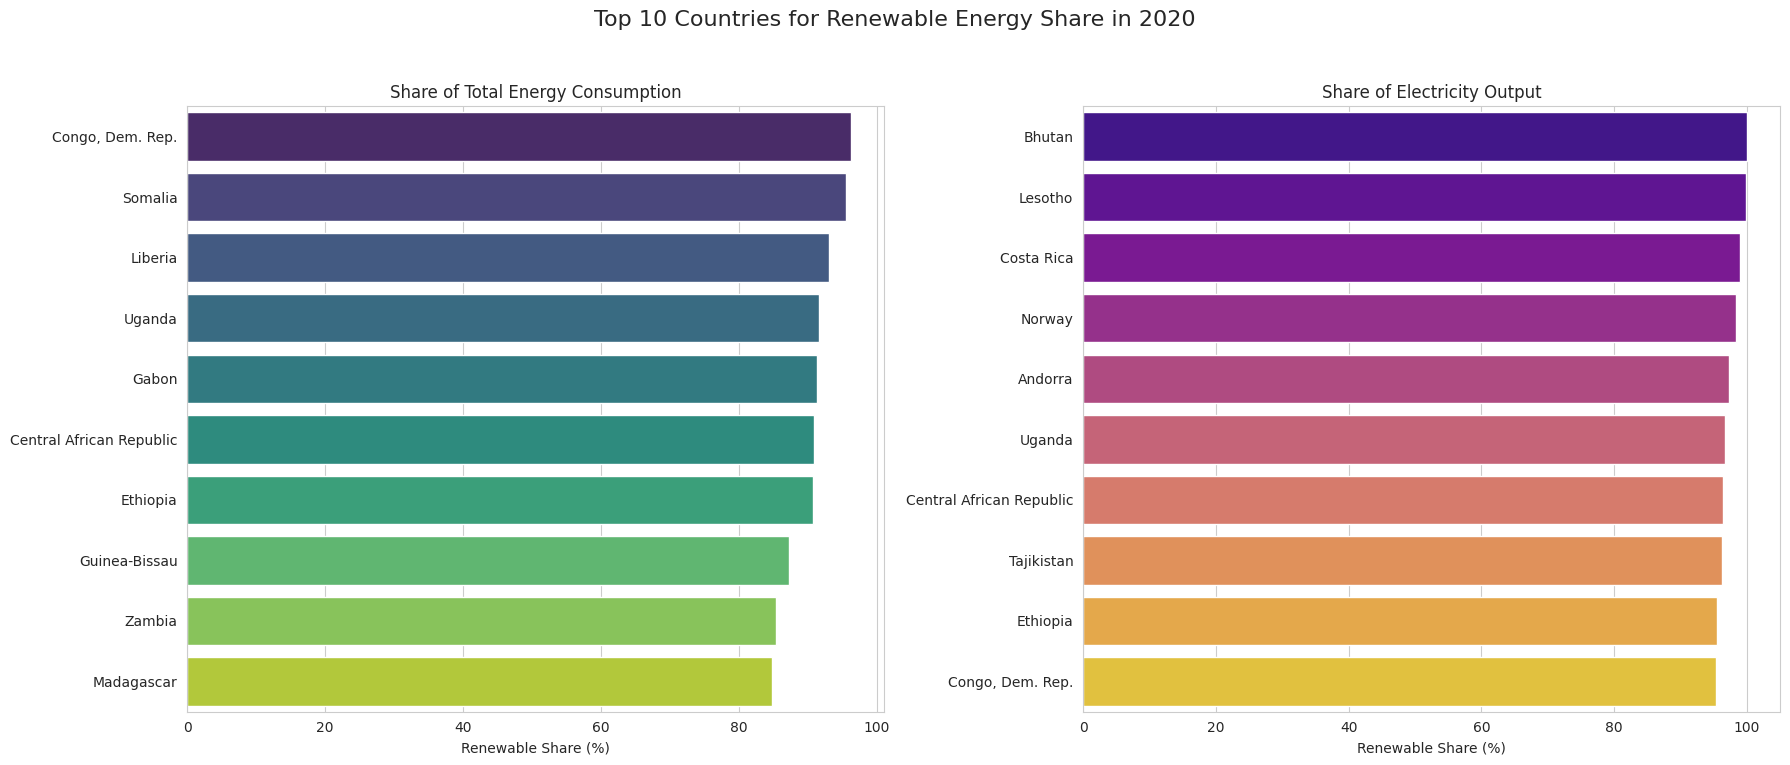

In [31]:
# --- Leaderboard Visualizations ---

# Set the style
sns.set_style("whitegrid")

# Create a figure for our two plots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Top 10 Countries for Renewable Energy Share in 2020', fontsize=16)

# --- Plot 1: Top 10 by Total Energy Consumption % ---
# Prepare data: drop rows with missing values for this metric and get top 10
top_10_consumption = df_2020.dropna(subset=['Consumption_Percent']).sort_values(by='Consumption_Percent', ascending=False).head(10)
sns.barplot(ax=axes[0], x='Consumption_Percent', y='Country Name', data=top_10_consumption, palette='viridis')
axes[0].set_title('Share of Total Energy Consumption')
axes[0].set_xlabel('Renewable Share (%)')
axes[0].set_ylabel('') # Remove y-axis label for clarity

# --- Plot 2: Top 10 by Electricity Output % ---
# Prepare data: drop rows with missing values for this metric and get top 10
top_10_electricity = df_2020.dropna(subset=['ElecOutputRenewable_Percent']).sort_values(by='ElecOutputRenewable_Percent', ascending=False).head(10)
sns.barplot(ax=axes[1], x='ElecOutputRenewable_Percent', y='Country Name', data=top_10_electricity, palette='plasma')
axes[1].set_title('Share of Electricity Output')
axes[1].set_xlabel('Renewable Share (%)')
axes[1].set_ylabel('') # Remove y-axis label for clarity


# Adjust layout and display plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### **Analysis 4: Comparing the Journeys of Specific Countries**
**Goal:** To understand that different countries follow unique paths in their energy transition.
**Methodology:** We selected four diverse countries (Germany, China, Norway, USA) and plotted their renewable electricity share over time on a single line chart to compare their trajectories.

##### **Chart Analysis: A Tale of Four Countries**
Each line tells a different story:
* **Norway:** Is a long-standing leader, starting and ending the period with a share close to 100%, thanks to its immense, decades-old hydropower infrastructure.
* **Germany:** Shows a steep, rapid increase, a direct result of its aggressive *Energiewende* national policy and powerful incentives for wind and solar.
* **China & USA:** Show steadier, more gradual growth. China, despite being the world's largest builder of new renewables, has its percentage growth tempered by its massive and growing total energy demand.

In [32]:
# --- Analysis 4: Comparing Country Journeys ---

# 1. Define the list of countries we want to compare
countries_to_compare = ['Germany', 'China', 'Norway', 'United States']

# 2. Filter the main DataFrame for these countries and for the years 2000-2020
df_comparison = final_df[
    (final_df['Country Name'].isin(countries_to_compare)) &
    (final_df['Year'] <= 2020)
].copy()

print(f"Created a new DataFrame 'df_comparison' for: {countries_to_compare}")

Created a new DataFrame 'df_comparison' for: ['Germany', 'China', 'Norway', 'United States']


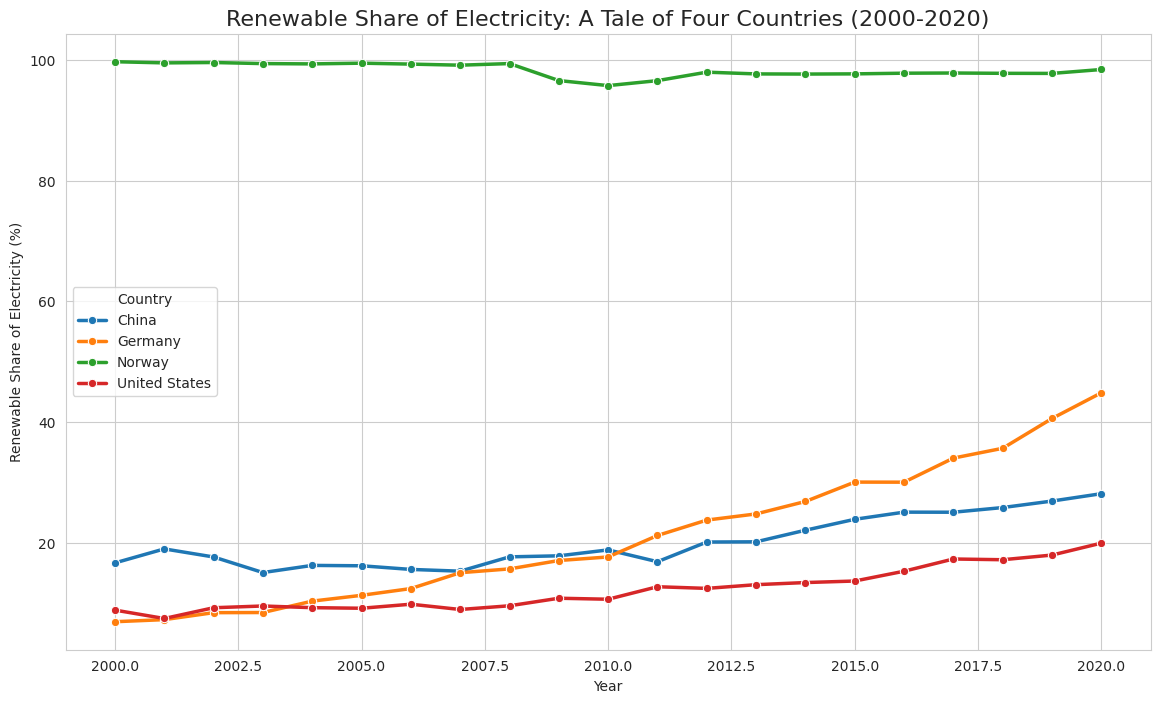

In [33]:
# --- Comparative Visualization ---

# Set the style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(14, 8))

# Create the line plot with a different line for each country
sns.lineplot(
    data=df_comparison,
    x='Year',
    y='ElecOutputRenewable_Percent',
    hue='Country Name', # This tells seaborn to draw a line for each unique country name
    marker='o',
    linewidth=2.5
)

# Add title and labels
plt.title('Renewable Share of Electricity: A Tale of Four Countries (2000-2020)', fontsize=16)
plt.ylabel('Renewable Share of Electricity (%)')
plt.xlabel('Year')

# Add a legend
plt.legend(title='Country')

# Display the plot
plt.show()

#### **Analysis 5: Comparing Major World Regions**
**Goal:** To zoom back out and compare progress across major world regions.
**Methodology:** We selected seven major regional aggregates and plotted their renewable electricity share over time on a single line chart.

##### **Chart Analysis: Regional Comparison**
The chart reveals significant regional disparities.
* **Latin America & Caribbean:** Has been the long-standing leader, a legacy of its massive hydropower resources built over decades.
* **European Union:** Shows the steepest growth, especially after 2010, driven by coordinated, bloc-wide policy.
* **South Asia:** Lags significantly in percentage terms, not from a lack of effort, but because its explosive growth in energy demand (and reliance on coal) outpaces even its rapid deployment of new renewables.

In [34]:
 # --- Analysis 5: Comparing Regional Journeys ---

# 1. Define the list of regions we want to compare
regions_to_compare = [
    'North America',
    'European Union',
    'East Asia & Pacific',
    'Latin America & Caribbean',
    'South Asia',
    'Sub-Saharan Africa',
    'Middle East & North Africa'
]

# 2. Filter the main DataFrame for these regions and for the years 2000-2020
df_regional = final_df[
    (final_df['Country Name'].isin(regions_to_compare)) &
    (final_df['Year'] <= 2020)
].copy()

print(f"Created a new DataFrame 'df_regional' for: {regions_to_compare}")

Created a new DataFrame 'df_regional' for: ['North America', 'European Union', 'East Asia & Pacific', 'Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa', 'Middle East & North Africa']


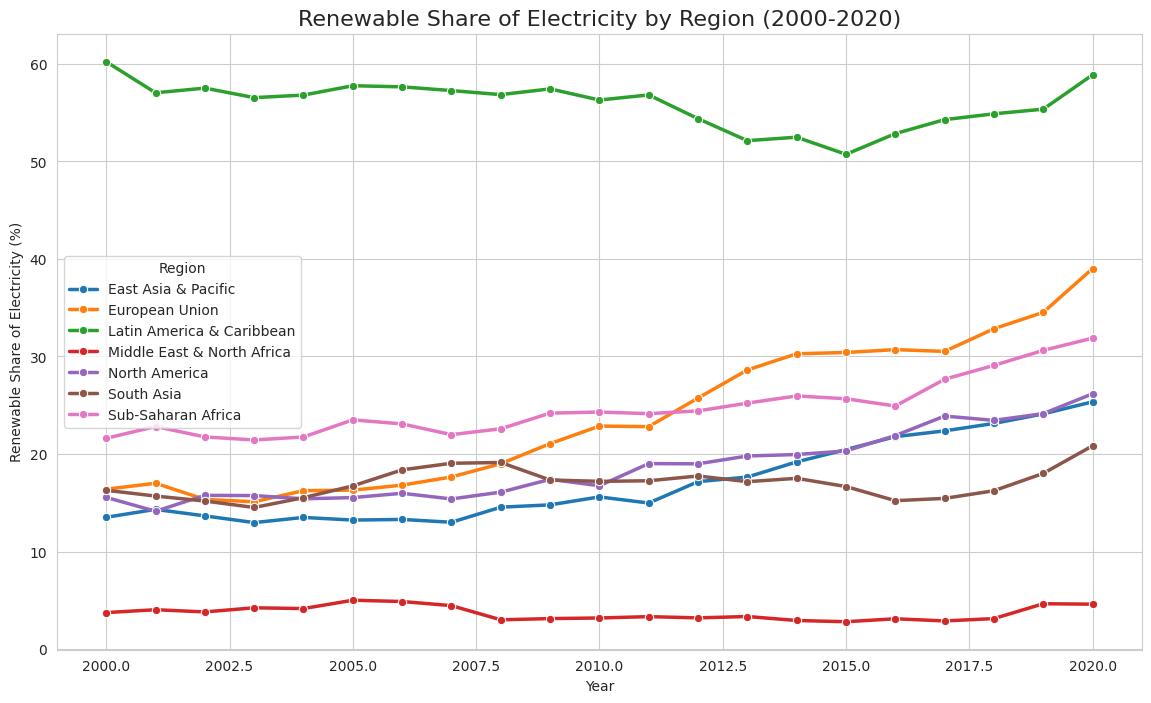

In [35]:
# --- Regional Comparative Visualization ---

# Set the style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(14, 8))

# Create the line plot with a different line for each region
sns.lineplot(
    data=df_regional,
    x='Year',
    y='ElecOutputRenewable_Percent',
    hue='Country Name', # This tells seaborn to draw a line for each unique region name
    marker='o',
    linewidth=2.5
)

# Add title and labels
plt.title('Renewable Share of Electricity by Region (2000-2020)', fontsize=16)
plt.ylabel('Renewable Share of Electricity (%)')
plt.xlabel('Year')

# Add a legend
plt.legend(title='Region')

# Display the plot
plt.show()

#### **Analysis 6: A Deep Dive into Latin America**
**Goal:** To investigate if the high regional average for Latin America is uniform or driven by specific countries.
**Methodology:** We selected a representative sample of six Latin American countries and plotted their renewable electricity share over time.

##### **Chart Analysis: Latin America Deep Dive**
This analysis reveals significant diversity within the leading region.
* The high average is driven by hyper-performers like Costa Rica and hydro-rich countries like Brazil and Colombia.
* Other major economies like Mexico and Argentina have a much lower share, closer to the world average.
* The chart also reveals interesting trends, such as Chile's recent "V-shaped" curve—a dip followed by a rapid increase, reflecting a hugely successful recent push into solar and wind power to diversify its energy mix.

In [36]:
# --- Analysis 6: Latin America Deep Dive ---

# 1. Define the list of Latin American countries we want to compare
# This list includes a mix of major economies and top performers.
la_countries_to_compare = [
    'Brazil',
    'Mexico',
    'Argentina',
    'Colombia',
    'Chile',
    'Costa Rica'
]

# 2. Filter the main DataFrame for these countries and for the years 2000-2020
df_la_comparison = final_df[
    (final_df['Country Name'].isin(la_countries_to_compare)) &
    (final_df['Year'] <= 2020)
].copy()

print(f"Created a new DataFrame 'df_la_comparison' for: {la_countries_to_compare}")

Created a new DataFrame 'df_la_comparison' for: ['Brazil', 'Mexico', 'Argentina', 'Colombia', 'Chile', 'Costa Rica']


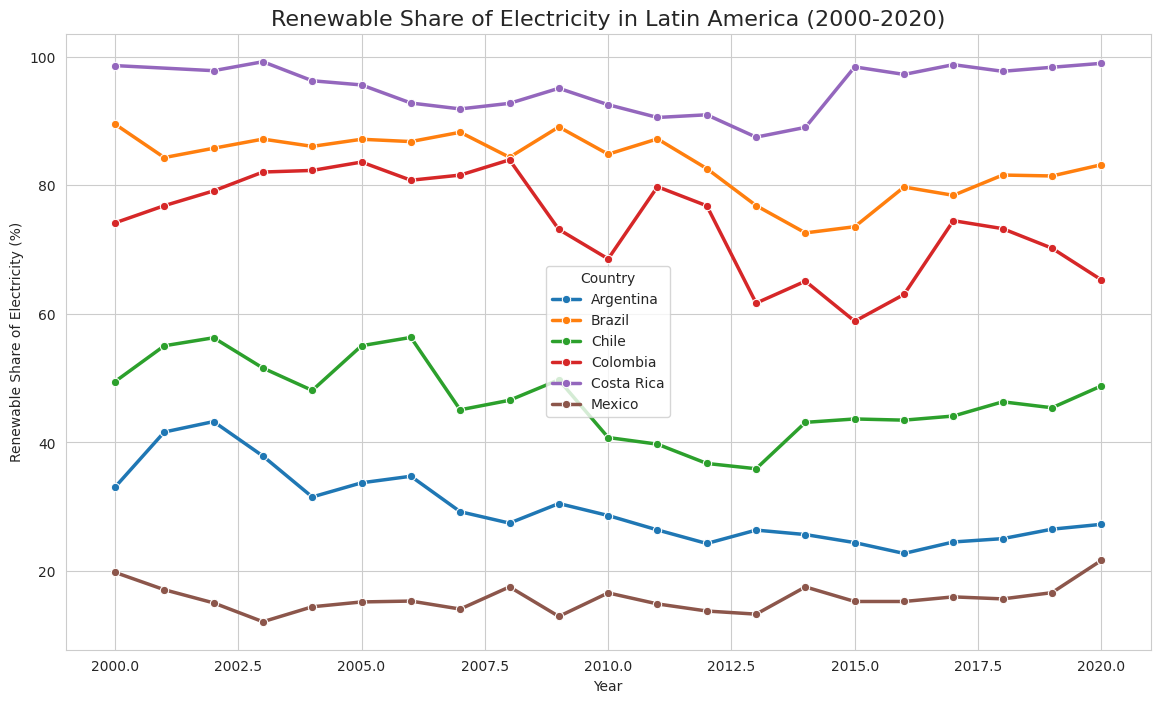

In [37]:
# --- Latin America Comparative Visualization ---

# Set the style
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(14, 8))

# Create the line plot
sns.lineplot(
    data=df_la_comparison,
    x='Year',
    y='ElecOutputRenewable_Percent',
    hue='Country Name', # A different line for each country
    marker='o',
    linewidth=2.5
)

# Add title and labels
plt.title('Renewable Share of Electricity in Latin America (2000-2020)', fontsize=16)
plt.ylabel('Renewable Share of Electricity (%)')
plt.xlabel('Year')

# Add a legend
plt.legend(title='Country')

# Display the plot
plt.show()